In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

import pyAgrum.skbn as skbn

import causalml.inference.meta.slearner as slearner
import causalml.inference.meta.tlearner as tlearner
import causalml.inference.meta.xlearner as xlearner
import causalml.inference.meta.rlearner as rlearner

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from estimation_class.estimators import estimator
from estimation_class.ATEestimation import ATEestimation

In [4]:
# Model parameters
XI = np.array([-1, 1, 1])
NU = np.array([0, -1, 1, -1, 2])
BETA = np.array([0, 0.6, -0.6, 0.6])
TAU_0 = np.array([-1, -1, 1, 1])
TAU_1 = TAU_0 * -1
SIGMA = np.array([[1, 0.5, -0.5, -0.5],
                  [0.5, 1, -0.5, -0.5],
                  [-0.5, -0.5, 1, 0.5],
                  [-0.5, -0.5, 0.5, 1]], dtype=float)

#SIGMA = np.ones((4,4)) * 0.001

def generate_lunceford(n=1000):
    # Generate data
    x3 = np.random.binomial(1, 0.2, n)
    v3 = np.random.binomial(1, (0.75 * x3 + (0.25 * (1 - x3))), n)

    # If x3=0 you have a model, if x3=1 you have another one
    x1v1x2v2_x3_0_matrix = np.random.multivariate_normal(TAU_0, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3_1_matrix = np.random.multivariate_normal(TAU_1, SIGMA, size=n, check_valid='warn', tol=1e-8)
    x1v1x2v2_x3 = np.where(np.repeat(x3[:, np.newaxis], 4, axis=1) == 0, x1v1x2v2_x3_0_matrix, x1v1x2v2_x3_1_matrix)

    # Concatenate values
    xv = np.concatenate([x1v1x2v2_x3, np.expand_dims(x3, axis=1), np.expand_dims(v3, axis=1)], axis=1)

    # Compute e, a, and y
    x = xv[:, [0,2,4]]
    v = xv[:, [1,3,5]]
    e = np.power(1 + np.exp(- BETA[0] - x.dot(BETA[1:])), -1)
    a = np.random.binomial(1, e, n)
    y = x.dot(NU[1:-1]) + v.dot(XI) + a*NU[-1] + np.random.binomial(1, e, n) + np.random.normal(0, 1, n)

    # Create the final df
    synthetic_data_df = pd.DataFrame(np.concatenate([x, np.expand_dims(a, axis=1), v, np.expand_dims(y, axis=1)], axis=1), columns=["X1", "X2", "X3", "T", "V1", "V2", "V3", "Y"])
    synthetic_data_df["X3"] = synthetic_data_df["X3"].astype(int)
    synthetic_data_df["V3"] = synthetic_data_df["V3"].astype(int)
    synthetic_data_df["T"] = synthetic_data_df["T"].astype(int)

    return synthetic_data_df

In [5]:
df = generate_lunceford(int(1e6))
df.head()

,X1,X2,X3,T,V1,V2,V3,Y
0,-1.886502,2.095999,0,0,-1.900783,1.105022,0,7.710674
1,0.161057,1.626828,0,0,-0.246868,0.675737,0,3.400747
2,-2.042650,1.732462,0,0,-3.571107,1.370377,0,7.865520
3,-1.679866,1.807459,0,0,-2.575824,1.475074,0,7.130761
4,-0.595700,-0.559324,0,1,0.100342,0.579626,0,2.517686


In [6]:
def getBN(# Covariate parameters
          covariate_start : int = -5.0,
          covariate_end : int = 5.0 ,
          covariate_num_split : int = 10,
          # Outcome parameters
          outcome_start = -10.0 ,
          outcome_end = 15.0 ,
          outcome_num_split = 60,
          # Other
          data : pd.DataFrame | None = None,
          add_arcs : bool = True,
          fill_distribution : bool = True) -> gum.BayesNet:
    """
    Returns Baysian Network corresponding to the model by discretising
    countinous variables with given parameters.
    """
    if data is None:
        plus = "" if fill_distribution else "+"
        bn = gum.BayesNet()
        for i in range(1,3):
            bn.add(f"X{i}{plus}[{covariate_start}:{covariate_end}:{covariate_num_split}]")
            bn.add(f"V{i}{plus}[{covariate_start}:{covariate_end}:{covariate_num_split}]")
        bn.add(f"X3[2]")
        bn.add(f"V3[2]")
        bn.add("T[2]")
        bn.add(f"Y{plus}[{outcome_start}:{outcome_end}:{outcome_num_split}]")

    else :
        disc = skbn.BNDiscretizer(defaultDiscretizationMethod="uniform",
                                  defaultNumberOfBins=covariate_num_split)
        disc.setDiscretizationParameters("X3", 'NoDiscretization', [0, 1])
        disc.setDiscretizationParameters("V3", 'NoDiscretization', [0, 1])
        disc.setDiscretizationParameters("T", 'NoDiscretization', [0, 1])
        disc.setDiscretizationParameters("Y", 'uniform', outcome_num_split)
        bn = disc.discretizedBN(data)

    if add_arcs :
        bn.beginTopologyTransformation()
        for _, name in bn:
            if name != "Y":
                bn.addArc(name, "Y")
        for X in ["X1", "X2", "X3"]:
            bn.addArc(X, "T")
        for XV in ["X1", "V1", "X2", "V2"]:
            bn.addArc("X3", XV)
        bn.addArc("X3", "V3")
        bn.endTopologyTransformation()

    if add_arcs and fill_distribution:
        bn.cpt("X3").fillWith([0.8, 0.2])
        bn.cpt("V3")[:] = [[0.75, 0.25], [0.25, 0.75]]
        for XV in ["X", "V"]:
            bn.cpt(f"{XV}1").fillFromDistribution(norm, loc="2*X3-1", scale=1)
            bn.cpt(f"{XV}2").fillFromDistribution(norm, loc="1-2*X3", scale=1)
        bn.cpt("T").fillFromDistribution(logistic, loc="-0.6*X1+0.6*X2-0.6*X3", scale=1)
        bn.cpt("Y").fillFromDistribution(norm, loc="-X1+X2-X3+2*T-V1+V2+V3", scale=1)

    return bn

In [7]:
empty_bn = getBN(data=df, fill_distribution=False)
cslbn = csl.CausalModel(empty_bn)
cslbn

In [8]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor

In [9]:
est = estimator(df=df, 
                cslbn=cslbn, 
                treatment="T", 
                outcome="Y", 
                covariates={"X1", "X2", "X3"}
)#conditional={"X1":1, "X2":10, "X3":1, "V1":1, "V2":1, "V3":1})

In [10]:
X = {"X1", "X2", "X3"}
T = "T"
y = "Y"

In [67]:
slearn = slearner.BaseSLearner(learner=LinearRegression())
slearn.estimate_ate(X=df[[*X]], treatment=df[T], y=df[y], return_ci=False)

array([2.01829226])

In [66]:
slearn.fit(X=df[[*X]], treatment=df[T], y=df[y])
slearn.predict(X=df[[*X]][:10], treatment=df[T][:10], y=df[y][:10])

array([[2.01829226],
       [2.01829226],
       [2.01829226],
       [2.01829226],
       [2.01829226],
       [2.01829226],
       [2.01829226],
       [2.01829226],
       [2.01829226],
       [2.01829226]])

In [14]:
s_est = est.Slearner(LinearRegression())
print(s_est)
print(np.abs(s_est-2))

2.0150001681477576
0.01500016814775762


In [17]:
tlearn = tlearner.BaseTLearner(learner=LinearRegression())
tlearn.estimate_ate(X=df[[*X]], treatment=df[T], y=df[y])

(array([2.01458016]), array([2.00756835]), array([2.02159197]))

In [20]:
tlearn.fit(X=df[[*X]], treatment=df[T], y=df[y])
tlearn.predict(X=df[[*X]][:10], treatment=df[T][:10], y=df[y][:10])

array([[2.01627046],
       [2.0237661 ],
       [2.01797679],
       [2.01840282],
       [2.03445612],
       [2.02368936],
       [2.01719765],
       [2.02096092],
       [1.97898807],
       [2.03728594]])

In [ ]:
t_est = est.Tlearner(LinearRegression())
print(t_est)
print(np.abs(t_est-2))

2.0120433148066015
0.01204331480660148


In [44]:
conditional = {"T":1, "V3":2}
query_string = ' and '.join([f'{key} == {value}' for key, value in conditional.items()])
query_string
assert len(df.query(query_string)) == 2, \
"Control group level not found in treatment vector."

AssertionError: Control group level not found in treatment vector.

In [50]:
xlearn = xlearner.BaseXLearner(learner=LinearRegression())


In [51]:
xlearn.estimate_ate(X=df[[*X]], treatment=df[T], y=df[y], n_bootstraps=5, bootstrap_size=100)

(array([2.01268046]), array([2.00566147]), array([2.01969944]))

In [311]:
x_est = est.Xlearner(LinearRegression())
print(x_est)
print(np.abs(x_est-2))

2.0120433148065913
0.012043314806591265


In [312]:
ps_est = est.Pstrat()
print(ps_est)
print(np.abs(ps_est-2))

/home/thierry/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


1.999466084458273
0.0005339155417269925


In [313]:
ipw_est = est.IPW()
print(ipw_est)
print(np.abs(ipw_est-2))

1.9958012259410813
0.004198774058918664


In [314]:
aipw_est = est.AIPW(LinearRegression())
print(aipw_est)
print(np.abs(aipw_est-2))

2.005128083981587
0.005128083981587039


In [53]:
rlearn = rlearner.BaseRLearner(learner=LinearRegression())
rlearn.estimate_ate(X=df[[*X]], treatment=df[T], y=df[y], n_bootstraps=5, bootstrap_size=100)

(array([2.00124676]), array([2.00123946]), array([2.00125406]))

In [219]:
est.Rlearner2(LinearRegression())

1.279662399006032

In [174]:
bn_collider = gum.fastBN("X<-T->Y;Y->X")
bn_collider

(pyAgrum.BayesNet<double>@0x60eea7f13180) BN{nodes: 3, arcs: 3, domainSize: 8, dim: 7, mem: 112o}

In [186]:
col_ate = list()
col_est_ate = list()

for i in range(1000):
    bn_collider = gum.fastBN("X<-T->Y;Y->X")
    df_collider, _ = gum.generateSample(bn_collider, n=10000)
    df_collider = df_collider.astype(int)

    ate_est = ATEestimation(df_collider)
    ate_est.X = X
    ate_est.T = T
    ate_est.y = y

    cslbn = csl.CausalModel(bn_collider)
    _, cpt1, _ = csl.causalImpact(cslbn, on="Y", doing="T", values={"T":1})
    _, cpt0, _ = csl.causalImpact(cslbn, on="Y", doing="T", values={"T":0})

    diff = cpt1 - cpt0

    estimate = ate_est.estimateCausalEffect(algorithm=tlearner.BaseTLearner(learner=LinearRegression()))

    col_ate.append(diff[1])
    col_est_ate.append(estimate[0][0])
    print(".", end="")

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [188]:
fork_ate = list()
fork_est_ate = list()

for i in range(1000):
    bn_fork = gum.fastBN("X->T->Y;Y<-X")
    df_fork, _ = gum.generateSample(bn_fork, n=10000)
    df_fork = df_fork.astype(int)

    ate_est = ATEestimation(df_fork)
    ate_est.X = X
    ate_est.T = T
    ate_est.y = y

    cslbn = csl.CausalModel(bn_fork)
    _, cpt1, _ = csl.causalImpact(cslbn, on="Y", doing="T", values={"T":1})
    _, cpt0, _ = csl.causalImpact(cslbn, on="Y", doing="T", values={"T":0})

    diff = cpt1 - cpt0

    estimate = ate_est.estimateCausalEffect(algorithm=tlearner.BaseTLearner(learner=LinearRegression()))

    fork_ate.append(diff[1])
    fork_est_ate.append(estimate[0][0])
    print(".", end="")

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

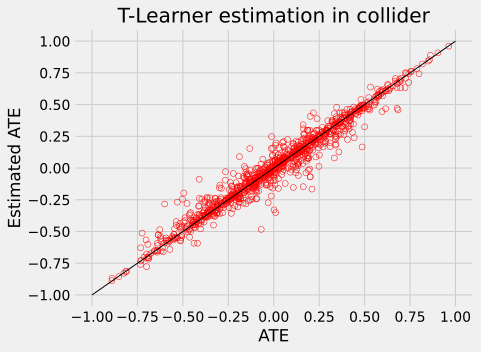

In [204]:
plt.scatter(col_ate, col_est_ate, facecolors='none', edgecolors='r')
plt.plot([-1,1],[-1,1], color="black", linewidth=1)
plt.title("T-Learner estimation in collider")

plt.xlabel("ATE")
plt.ylabel("Estimated ATE")
plt.show()

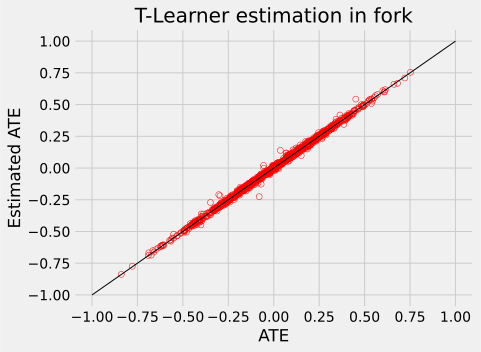

In [203]:
plt.scatter(fork_ate, fork_est_ate, facecolors='none', edgecolors='r')
plt.plot([-1,1],[-1,1], color="black", linewidth=1)
plt.title("T-Learner estimation in fork")

plt.xlabel("ATE")
plt.ylabel("Estimated ATE")
plt.show()

In [207]:
gum.fastBN("X->T->Z;X->Y->Z;T->Y")

(pyAgrum.BayesNet<double>@0x60ee9b3d8150) BN{nodes: 4, arcs: 5, domainSize: 16, dim: 11, mem: 176o}

In [214]:
ate = list()
est_ate_partial = list()
est_ate_total = list()

for i in range(1000):
    bn = gum.fastBN("X->T->Z;X->Y->Z;T->Y")
    df, _ = gum.generateSample(bn, n=10000)
    df = df.astype(int)

    cslbn = csl.CausalModel(bn)
    _, cpt1, _ = csl.causalImpact(cslbn, on="Y", doing="T", values={"T":1})
    _, cpt0, _ = csl.causalImpact(cslbn, on="Y", doing="T", values={"T":0})

    diff = cpt1 - cpt0

    ate.append(diff[1])

    ate_est = ATEestimation(df)
    ate_est.T = "T"
    ate_est.y = "Y"

    ate_est.X = {"X", "Z"}
    estimate = ate_est.estimateCausalEffect(algorithm=tlearner.BaseTLearner(learner=LinearRegression()))
    est_ate_total.append(estimate[0][0])

    ate_est.X = {"X"}
    estimate = ate_est.estimateCausalEffect(algorithm=tlearner.BaseTLearner(learner=LinearRegression()))
    est_ate_partial.append(estimate[0][0])

    print(".", end="")

ate = np.array(ate)
est_ate_partial = np.array(est_ate_partial)
est_ate_total = np.array(est_ate_total)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

invalid value encountered in divide


....................................................................................................................................................................

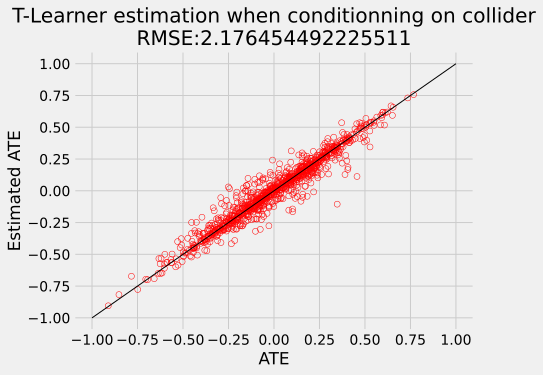

In [218]:
plt.scatter(ate, est_ate_total, facecolors='none', edgecolors='r')
plt.plot([-1,1],[-1,1], color="black", linewidth=1)
plt.title(f"T-Learner estimation when conditionning on collider\nRMSE:{np.linalg.norm(ate-est_ate_total, ord=2)}")

plt.xlabel("ATE")
plt.ylabel("Estimated ATE")
plt.show()

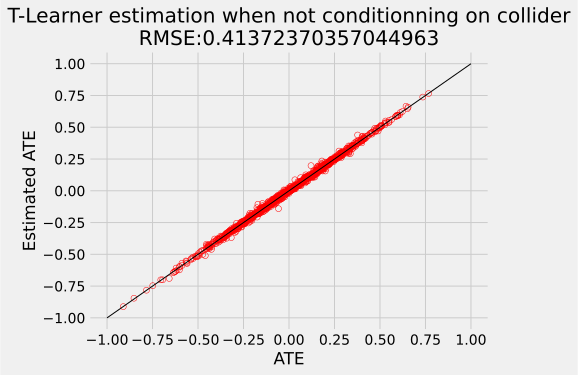

In [217]:
plt.scatter(ate, est_ate_partial, facecolors='none', edgecolors='r')
plt.plot([-1,1],[-1,1], color="black", linewidth=1)
plt.title(f"T-Learner estimation when not conditionning on collider\nRMSE:{np.linalg.norm(ate-est_ate_partial, ord=2)}")

plt.xlabel("ATE")
plt.ylabel("Estimated ATE")
plt.show()

In [172]:
import pyAgrum.causal as csl

In [114]:
ate_estimator = ATEestimation(df)
ate_estimator.X = {"X1", "X2", "X3"}
ate_estimator.T = "T"
ate_estimator.y = "Y"

In [116]:
ate_estimator.fitEstimator(estimator="TLearner", estimator_params={"learner":LinearRegression()})

In [117]:
ate_estimator.estimateCausalEffect(conditional=df.loc[[0,4,1,8]])

array([[2.01627046],
       [2.03445612],
       [2.0237661 ],
       [1.97898807]])

In [97]:
df.loc[:0][["X1", "X2", "X3"]].to_numpy()

array([[-1.88650238,  2.09599898]])

In [107]:
slearn.predict(X=df.loc[[0,4]][["X1", "X2", "X3"]], treatment=df.loc[[0,4]]["T"], y=df.loc[[0,4]]["Y"])

invalid value encountered in scalar divide


array([[2.01829226],
       [2.01829226]])